# Data Preparation

In [93]:
#Importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### Loading the datasets

In [94]:
fear_greed_df = pd.read_csv(r'Datasets\fear_greed_index.csv')
print(f"Data shape : {fear_greed_df.shape}") #finding the number of rows and columns 
print(f"Is there any missing values : {fear_greed_df.isnull().values.any()}") #checking if there's any missing values
print(f"Is there any duplicates : {fear_greed_df.duplicated().any()}") #checking if there's any duplicates

Data shape : (2644, 4)
Is there any missing values : False
Is there any duplicates : False


- The fear_greed_df dataset have 2644 rows and 4 columns
- There's no missing values or duplicate records in the data

In [95]:
historical_df = pd.read_csv(r'Datasets\historical_data.csv')
print(f"Data shape : {historical_df.shape}") #finding the number of rows and columns 
print(f"Is there any missing values : {historical_df.isnull().values.any()}") #checking if there's any missing values
print(f"Is there any duplicates : {historical_df.duplicated().any()}") #checking if there's any duplicates

Data shape : (211224, 16)
Is there any missing values : False
Is there any duplicates : False


- The historical_df dataset have 211224 rows and 16 columns
- There's no missing values or duplicate records in the dataset

##### Cleaning the datasets

In [96]:
fear_greed_df.drop(columns = 'date', inplace = True) #removing the date column as timestamp column is much reliable to use
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['timestamp'], unit = 's').dt.normalize() #creating a column named 'date' using the timestamp column, keeping only the date
fear_greed_df.drop(columns = 'timestamp', inplace = True) #removing the timestamp column

In [97]:
#removing unnecessary columns from historical data that we don't need for analysis
historical_df = historical_df.drop(columns = ['Transaction Hash','Order ID','Crossed','Trade ID','Timestamp'])

In [98]:
#Standardizing the Timestamp IST column, by keeping only the date part
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], dayfirst = True).dt.normalize()
historical_df = historical_df.rename(columns = {'Timestamp IST':'date'}) #renaming the column to 'date'

##### Aligning the datasets

In [99]:
df_merged = pd.merge(left = historical_df, right = fear_greed_df, how = 'left')

##### Creating Key Metrics

In [100]:
#finding the daily pnl per trader
daily_pnl = df_merged.groupby(['Account','date'])['Closed PnL'].sum().reset_index()

In [101]:
#finding the win rate of each trader
df_merged['win'] = df_merged['Closed PnL'] > 0 #creating a column where the closed pnl is greater than 0
win_rate = df_merged.groupby('Account')['win'].mean()*100 
win_rate = win_rate.reset_index().round(2) #making it into a dataframe and rounding the win rate to two decimals

In [102]:
#finding the overall win rate
overall_win_rate = df_merged['win'].mean() * 100 
overall_win_rate = overall_win_rate.round(2)

In [103]:
#finding the average trade size per trader
avg_trade_size = df_merged.groupby('Account')['Size USD'].mean().reset_index()
avg_trade_size.rename(columns = {'Size USD' : 'Avg_trade_size (USD)'},inplace = True) #renaming the column for clarity

In [104]:
#finding the number of trades per day
trades_per_day = df_merged.groupby('date').size().reset_index(name = 'total_trades')

In [105]:
#finding the overall long/short ratio
counts = df_merged['Side'].value_counts()
overall_long_short_ratio = (counts['BUY'] / counts['SELL']) 
overall_long_short_ratio = overall_long_short_ratio.round(2)

# Analysis

#### 1. Does performance differ between Fear vs Greed days?


In [106]:
#Creating a table to analyze how performance vary based on sentiments
performance_analysis = df_merged.groupby('classification').agg({'Closed PnL' : ['sum','mean','min'],'win': 'mean'}).reset_index()
performance_analysis.columns = ['Sentiment', 'Total PnL','Average PnL', 'Drawdown Proxy', 'Win Rate']
performance_analysis.set_index('Sentiment', inplace = True)

order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
performance_analysis = performance_analysis.loc[order]
performance_analysis = performance_analysis.round(2)
performance_analysis['Win Rate'] = performance_analysis['Win Rate'] * 100
performance_analysis

,Total PnL,Average PnL,Drawdown Proxy,Win Rate
Sentiment,,,,
Extreme Fear,739110.25,34.54,-31036.69,37.0
Fear,3357155.44,54.29,-35681.75,42.0
Neutral,1292920.68,34.31,-24500.00,40.0
Greed,2150129.27,42.74,-117990.10,38.0
Extreme Greed,2715171.31,67.89,-10259.47,46.0


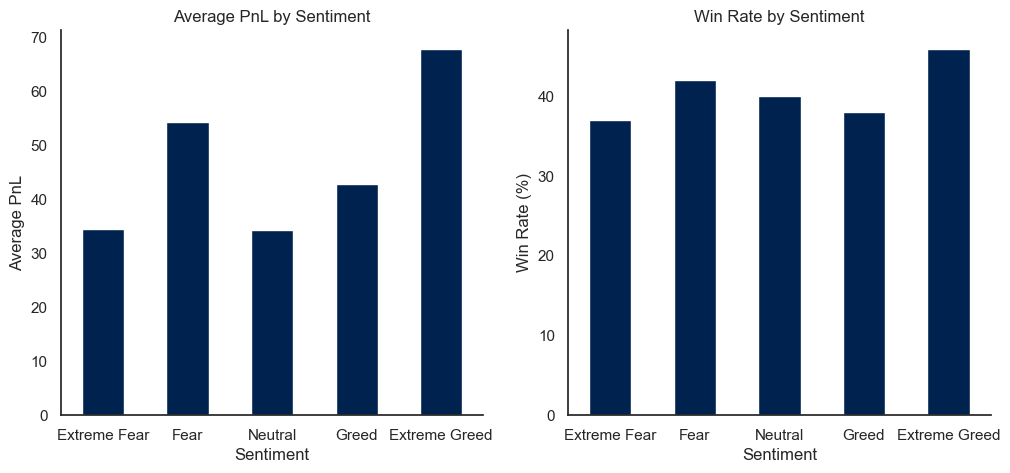

In [107]:
sns.set_theme(style = 'white') #setting theme using seaborn
fig, ax = plt.subplots(1,2, figsize =(12,5)) #creating two subplots

performance_analysis.plot(kind = 'bar', y = 'Average PnL', legend = False, ax = ax[0], colormap = 'cividis') #visualizing the average pnl based on sentiment
ax[0].set_title('Average PnL by Sentiment')
ax[0].tick_params(axis = 'x',rotation = 0)
ax[0].set_ylabel('Average PnL')

performance_analysis.plot(kind = 'bar', y = 'Win Rate', legend = False, ax = ax[1], colormap = 'cividis') #visualizing the win rate by sentiment
ax[1].set_title('Win Rate by Sentiment')
ax[1].tick_params(axis = 'x',rotation = 0)
ax[1].set_ylabel('Win Rate (%)')

sns.despine()
plt.show()

- Extreme Greed provides the highest Win Rate (46%) and Average PnL ($67.89). It proves that strong market momentum creates a "tailwinds" effect where trades are both easier to win and more profitable.

- While "Extreme Greed" is profitable, the Greed phase is the most dangerous, showing a massive Drawdown Proxy of -$117,990. This suggests that traders often over-leverage or take "hero trades" right before the market peaks, leading to catastrophic losses.

- The Neutral sentiment has the lowest Average PnL ($34.31). This indicates that directionless, "choppy" markets are actually harder to extract value from than fearful, volatile ones.

- Interestingly, Fear has a higher Average PnL ($54.29) than Greed. While it's harder to win (lower win rate), the successful trades in fearful markets tend to be larger, likely due to high volatility "bounces."

#### 2. Do traders change behavior based on sentiment?


In [108]:
#Creating a new column to find Long/Short Trade Bias
df_merged['Is_Long'] = df_merged['Direction'].str.contains('Long')

#Finding customer behavior metrics
behavior_metrics = df_merged.groupby('classification').agg({'date' : 'count', 'Size USD' : 'mean', 'Is_Long' : 'mean', 'Fee' : 'mean'})
#rounding every metrics to two decimals
behavior_metrics['Is_Long'] = (behavior_metrics['Is_Long'] * 100).round(2)
behavior_metrics['Size USD'] = behavior_metrics['Size USD'].round(2)
behavior_metrics['Fee'] = behavior_metrics['Fee'].round(2)

behavior_metrics = behavior_metrics.rename(columns = {'date' : 'Trade Count', 'Is_Long' : 'Long Trade Bias (%)'}).reindex(order) #ordering the sentiment

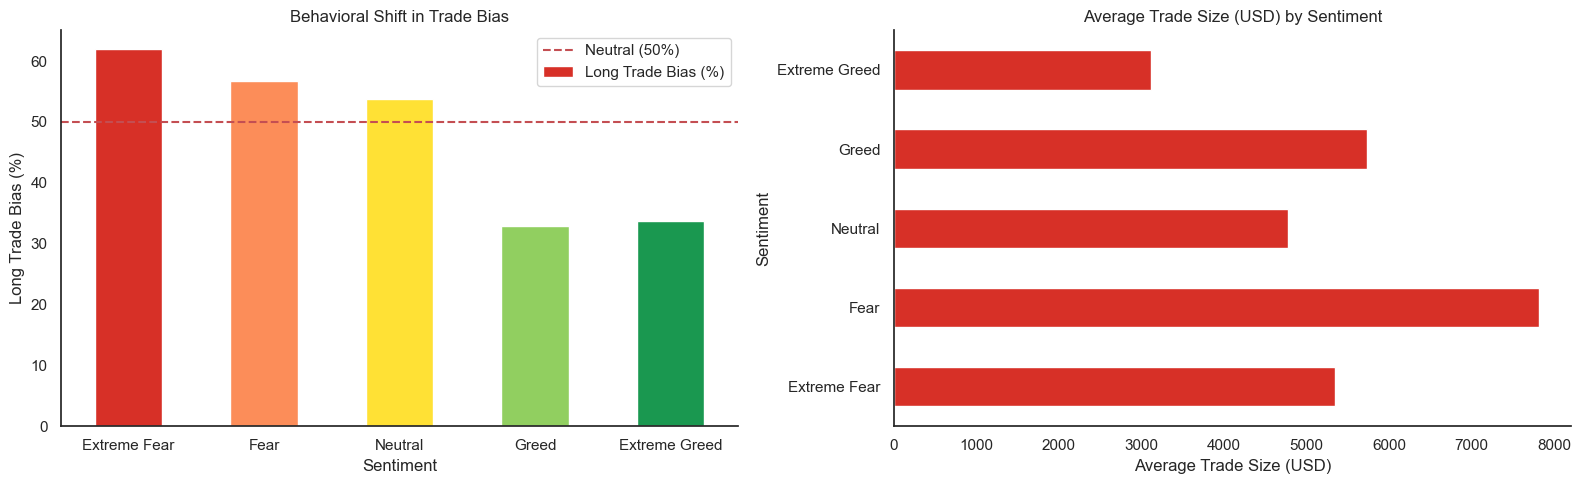

In [109]:
sns.set_theme(style = 'white')

fig, ax = plt.subplots(1, 2, figsize = (16,5))

sentiment_colors = ['#d73027', '#fc8d59', '#FFE135', '#91cf60', '#1a9850']
behavior_metrics.plot(kind = 'bar', y = 'Long Trade Bias (%)', legend = False, color = sentiment_colors, ax = ax[0]) #plotting the behavior shif in trade bias

ax[0].tick_params(axis = 'x', rotation = 0)
ax[0].axhline(y = 50, color = 'r', linestyle = '--', label = 'Neutral (50%)')
ax[0].legend()
ax[0].set_title('Behavioral Shift in Trade Bias')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Long Trade Bias (%)')

behavior_metrics['Size USD'].plot(kind = 'barh', color = '#d73027') #plotting average trade size of traders based on sentiment

ax[1].set_title('Average Trade Size (USD) by Sentiment')
ax[1].set_xlabel('Average Trade Size (USD)')
ax[1].set_ylabel('Sentiment')

sns.despine()
plt.tight_layout()
plt.show()

- The trader aggressively bets against the trend, reaching their highest Long Bias (61.95%) during Extreme Fear. While the crowd sells, this trader is "buying the dip," attempting to catch market bottoms.

- The trader increases their Average Position Size ($184k) during Extreme Fear, betting significantly more capital than they do during Extreme Greed ($156k). This "doubling down" in falling markets explains the massive drawdowns found in your earlier performance analysis.

- The Average Fee peaks in Fear ($1.50) and drops to its lowest in Extreme Greed ($0.68). This suggests "panic trading" during fearful times (using expensive market orders to exit/enter quickly) versus patient, cheaper execution when the market is booming.

- Trading activity is highest during Fear (618 trades) rather than the absolute extremes. The trader is most hyperactive when the market is transitioning, likely trying to "anticipate" the next big move before it happens.